# Mama's Bakery Franchise

***

## **Bussiness Problem**

### The group of inversion BakeryArmy has interest in making a franchise out of the products of a local bakery. Its main products are cakes and cookies that have a great reception at a local level. 
### BakeryArmy is willing to invest in opening several stores all around Mexico City's suburbs. In order to assure its success, we have to do an analysis of the best locations around the center of the 1812 suburbs of the city considering the nearest direct competitors.

***

## Data

### One of the best indicators to assure the success of a local business it's to check for local competitors. 
### First of all, we will use a public file of the locations of all the suburbs of Mexico City as reference. This file is avaialble at:  https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C 

### This file will help us perform an analysis with geo data using Foursquare. We will use the center of each suburb to check for the number of establishments that represent a direct competition to our franchise. 

### As from the possible Foursquare Venue Categories ( documented at: https://developer.foursquare.com/docs/build-with-foursquare/categories/ ) we will consider as direct competition the categories: Bakery, Cafeteria, Creperie and Donut Shop.


### The final objetive of the data analysis is to provide a quantitative evaluation of the best suburbs (considering them from their geographical center) to have insight on where to open franchise establishments.

***

***

## Methodology 

### In this project we will use the geographical center of each suburb in Mexico City to calculate the density of stabilshments that would represent a direct competitios to our franchise in a radius of 1 kilometer.
### First of all, let's obtain the data and visualize the center of each suburb in a map

In [2]:
import pandas as pd
import numpy as np

In [8]:
df_suburb= pd.read_csv("https://datos.cdmx.gob.mx/explore/dataset/coloniascdmx/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C")
df_suburb.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE CHAPULTEPEC,9.0,"19.4228411174,-99.2157935754","{""type"": ""Polygon"", ""coordinates"": [[[-99.2201...",16,MIGUEL HIDALGO,16-042,"4924, 4931, 4932, 4935, 4936, 4940, 4987","4923, 4937, 4938, 4939, 4942"
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),9.0,"19.4106158914,-99.2262487268","{""type"": ""Polygon"", ""coordinates"": [[[-99.2296...",16,MIGUEL HIDALGO,16-044,4963,4964
2,DEL BOSQUE (POLANCO),9.0,"19.4342189235,-99.2094037513","{""type"": ""Polygon"", ""coordinates"": [[[-99.2082...",16,MIGUEL HIDALGO,16-026,NaN,"4918, 4919"
3,PEDREGAL DE SANTA URSULA I,9.0,"19.314862237,-99.1477954505","{""type"": ""Polygon"", ""coordinates"": [[[-99.1458...",3,COYOACAN,03-135,"433, 500, 431, 513, 501","424, 425, 426, 430, 499"
4,AJUSCO I,9.0,"19.324571116,-99.1561602234","{""type"": ""Polygon"", ""coordinates"": [[[-99.1585...",3,COYOACAN,03-128,"376, 377, 378, 379, 404, 493, 498",374


### We change from spanish to english and drop data that will not be useful

In [9]:
df_suburb= df_suburb[['COLONIA', 'Geo Point']]
df_suburb.rename(columns={'COLONIA': 'Suburb'}, inplace=True)
df_suburb.head()

,Suburb,Geo Point
0,LOMAS DE CHAPULTEPEC,"19.4228411174,-99.2157935754"
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),"19.4106158914,-99.2262487268"
2,DEL BOSQUE (POLANCO),"19.4342189235,-99.2094037513"
3,PEDREGAL DE SANTA URSULA I,"19.314862237,-99.1477954505"
4,AJUSCO I,"19.324571116,-99.1561602234"


### As part of data preprocess we split de Geo Point into latitude and longitude

In [10]:
df_suburb=pd.concat([df_suburb[['Suburb']], df_suburb['Geo Point'].str.split(',', expand=True).astype(float)], axis=1)
df_suburb.head()

,Suburb,0,1
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249
2,DEL BOSQUE (POLANCO),19.434219,-99.209404
3,PEDREGAL DE SANTA URSULA I,19.314862,-99.147795
4,AJUSCO I,19.324571,-99.156160


### ...and rename the columns

In [11]:
df_suburb.columns=['Suburb','Latitude','Longitude']
df_suburb.head()

,Suburb,Latitude,Longitude
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249
2,DEL BOSQUE (POLANCO),19.434219,-99.209404
3,PEDREGAL DE SANTA URSULA I,19.314862,-99.147795
4,AJUSCO I,19.324571,-99.156160


### There are some Suburbs that do not have Latitude an Longitude information, and sice they are just a few in comparison to the whole set, we are just going to drop them

In [12]:
df_suburb.dropna(inplace=True)
df_suburb.isna().sum()

Suburb       0
Latitude     0
Longitude    0
dtype: int64

### Let´s visualize them in a map

### First we install some useful libraries

In [13]:
!pip install folium #Installing folium
!pip install geopy

     |████████████████████████████████| 92kB 16.9MB/s eta 0:00:01


In [14]:
import folium
from geopy.geocoders import Nominatim
import requests

### Getting the geodata of Mexico city 

In [15]:
address= 'MEXICO CITY, MEXICO'
geolocator = Nominatim(user_agent="CDMX_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


### We use our geo data to visualize de Suburbs as points in the map

In [16]:
map_mexico = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, suburb in zip(df_suburb['Latitude'], df_suburb['Longitude'], df_suburb['Suburb']):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mexico)  
    
map_mexico

## Geo Data Analysis with Foursquare

### We setup our Foursquare credentials

In [22]:
# The code was removed by Watson Studio for sharing.

### Since we are analyzing our data using the density of different kind of establishment that represent a direct competition, we will create 4 functions (one per each kind of competitor)  to get data of interest around each spot.
### In order to do so, we extracted de Venue ID of the competitors from the Foursquare documentation to search specifically for this kind of establishment.

In [23]:
from pandas.io.json import json_normalize

radius=1000
LIMIT=20
def getNearbyBakeries(names, latitudes, longitudes, radius=500):
    bakeryID='4bf58dd8d48988d16a941735'
    total_bakeries=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            bakeryID
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        total_bakeries.append(len(results))
    return(total_bakeries)

def getNearbyCafeterias(names, latitudes, longitudes, radius=500):
    cafeteriasID='4bf58dd8d48988d128941735'
    total_cafeterias=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            cafeteriasID
        )
            
        # make the GET request
        
        results = requests.get(url).json()["response"]['venues']
        total_cafeterias.append(len(results))
    return(total_cafeterias)

def getNearbyCreperies(names, latitudes, longitudes, radius=500):
    creperiesID='52e81612bcbc57f1066b79f2'
    total_creperies=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            creperiesID
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        total_creperies.append(len(results))
    return(total_creperies)

def getNearbyDonutShops(names, latitudes, longitudes, radius=500):
    donutsID='4bf58dd8d48988d148941735'
    total_donutshops=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            donutsID
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        total_donutshops.append(len(results))
    return(total_donutshops)


### Here we ran into a limitation. As we count only with the free plan of Foursquare, the number of max requests are exceeded for this project.
### We were forced to limit the number of Suburbs to analyze. We will take 100 samples of the set.

#### If you have a paid account of Foursquare that enables you to run through all the dataset, please feel free to use this code removing the slicing part of the arguments in each function

In [24]:
total_near_bakeries=getNearbyBakeries(names=df_suburb['Suburb'][0:100],latitudes=df_suburb['Latitude'][0:100],longitudes= df_suburb['Longitude'][0:100])
print("Done with bakeries")
total_near_cafeterias=getNearbyCafeterias(names=df_suburb['Suburb'][0:100],latitudes=df_suburb['Latitude'][0:100],longitudes= df_suburb['Longitude'][0:100])
print("Done with Cafeterias")
total_near_creperies= getNearbyCreperies(names=df_suburb['Suburb'][0:100],latitudes=df_suburb['Latitude'][0:100],longitudes= df_suburb['Longitude'][0:100])
print("Done with Creperies")
total_near_donutshops= getNearbyDonutShops(names=df_suburb['Suburb'][0:100],latitudes=df_suburb['Latitude'][0:100],longitudes= df_suburb['Longitude'][0:100])
print("Done with Donutshops")
print(total_near_bakeries[0:10])
print(total_near_cafeterias[0:10])
print(total_near_creperies[0:10])
print(total_near_donutshops[0:10])

Done with bakeries
Done with Cafeterias
Done with Creperies
Done with Donutshops
[7, 1, 13, 7, 8, 3, 10, 0, 5, 5]
[0, 0, 18, 0, 1, 1, 0, 1, 1, 1]
[0, 0, 2, 2, 1, 2, 4, 0, 5, 0]
[0, 0, 2, 0, 0, 2, 0, 0, 0, 2]


### Let's create a dataframe with the Number of each establishment and another column with the total sum of them

In [25]:
df=df_suburb[0:100]
df['TotalBakeries']= total_near_bakeries
df['TotalCafeterias']=total_near_cafeterias
df['TotalCreperies']=total_near_creperies
df['TotalDonutshops']=total_near_donutshops
df['TotalEstablishments']=df[['TotalBakeries','TotalCafeterias','TotalCreperies','TotalDonutshops']].sum(axis=1)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

,Suburb,Latitude,Longitude,TotalBakeries,TotalCafeterias,TotalCreperies,TotalDonutshops,TotalEstablishments
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,7,0,0,0,7
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249,1,0,0,0,1
2,DEL BOSQUE (POLANCO),19.434219,-99.209404,13,18,2,2,35
3,PEDREGAL DE SANTA URSULA I,19.314862,-99.147795,7,0,2,0,9
4,AJUSCO I,19.324571,-99.156160,8,1,1,0,10


### In order to have a better understanding of the data, we will normalize the result with a Min-Max Scaler

In [26]:
from sklearn import preprocessing

df['TotalBakeries']= preprocessing.MinMaxScaler().fit_transform(df[['TotalBakeries']]).astype(float).round(3)
df['TotalCafeterias']= preprocessing.MinMaxScaler().fit_transform(df[['TotalCafeterias']]).astype(float).round(3)
df['TotalCreperies']= preprocessing.MinMaxScaler().fit_transform(df[['TotalCreperies']]).astype(float).round(3)
df['TotalDonutshops']= preprocessing.MinMaxScaler().fit_transform(df[['TotalDonutshops']]).astype(float).round(3)
df['TotalEstablishments']= preprocessing.MinMaxScaler().fit_transform(df[['TotalEstablishments']]).astype(float).round(3)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Suburb,Latitude,Longitude,TotalBakeries,TotalCafeterias,TotalCreperies,TotalDonutshops,TotalEstablishments
0,LOMAS DE CHAPULTEPEC,19.422841,-99.215794,0.438,0.000,0.000,0.000,0.200
1,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),19.410616,-99.226249,0.062,0.000,0.000,0.000,0.029
2,DEL BOSQUE (POLANCO),19.434219,-99.209404,0.812,1.000,0.333,0.667,1.000
3,PEDREGAL DE SANTA URSULA I,19.314862,-99.147795,0.438,0.000,0.333,0.000,0.257
4,AJUSCO I,19.324571,-99.156160,0.500,0.056,0.167,0.000,0.286


### As a first approachment, we will consider the TotalEstablishments as the main factor to decide where to place our franchise. 
### So, we sort our dataframe by ascending values of the TotalEstablishment columns to determine the best locations

In [27]:
df.sort_values(by='TotalEstablishments',inplace=True)
df.reset_index(drop=True, inplace=True )
df.head(10)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Suburb,Latitude,Longitude,TotalBakeries,TotalCafeterias,TotalCreperies,TotalDonutshops,TotalEstablishments
0,SAN NICOLAS TETELCO (PBLO),19.217583,-98.975739,0.0,0.0,0.0,0.0,0.0
1,"AYOCATITLA, ASUNCIN",19.184543,-99.147997,0.0,0.0,0.0,0.0,0.0
2,XAXALCO,19.192328,-99.141508,0.0,0.0,0.0,0.0,0.0
3,TEMPILULI,19.278847,-99.028314,0.0,0.0,0.0,0.0,0.0
4,SAN MIGUEL (AMPL),19.293127,-98.974118,0.0,0.0,0.0,0.0,0.0
5,SAN JUAN TEPENAHUAC (PBLO),19.189675,-98.993892,0.0,0.0,0.0,0.0,0.0
6,LA PRIMAVERA,19.267178,-99.202916,0.0,0.0,0.0,0.0,0.0
7,LA HABANA,19.267860,-98.995855,0.0,0.0,0.0,0.0,0.0
8,CAROLOS PACHECO (U HAB),19.363832,-99.030063,0.0,0.0,0.0,0.0,0.0
9,LA ANGOSTURA,19.333006,-99.232437,0.0,0.0,0.0,0.0,0.0


### Selecting the worst locations

In [28]:
df.tail(10)

,Suburb,Latitude,Longitude,TotalBakeries,TotalCafeterias,TotalCreperies,TotalDonutshops,TotalEstablishments
90,IGNACIO ZARAGOZA I,19.413112,-99.094699,0.625,0.000,0.667,0.000,0.400
91,NUEVA STA ANITA,19.399062,-99.126820,0.875,0.056,0.167,0.000,0.457
92,SAUZALES CEBADALES (U HAB),19.297918,-99.110803,0.438,0.222,0.833,0.000,0.457
93,DEL MAESTRO,19.482761,-99.182304,0.812,0.222,0.000,0.000,0.486
94,LA OTRA BANDA,19.336889,-99.195036,0.688,0.278,0.333,0.333,0.543
95,5 DE MAYO,19.448459,-99.199910,0.625,0.278,0.667,0.000,0.543
96,OLIMPICA,19.304284,-99.170084,0.625,0.056,1.000,1.000,0.571
97,ARBOLEDAS DEL SUR,19.292791,-99.138919,0.562,0.611,0.167,0.000,0.600
98,TABACALERA,19.435776,-99.153949,1.000,0.667,0.500,0.000,0.886
99,DEL BOSQUE (POLANCO),19.434219,-99.209404,0.812,1.000,0.333,0.667,1.000


### Now that it's done, we can easily visualize the best suburbs to place our franchise

In [29]:
print("The best Suburbs from the set to place a franchise are: ")
print(df['Suburb'][df['TotalEstablishments']==0.00])

The best Suburbs from the set to place a franchise are: 
0     SAN NICOLAS TETELCO (PBLO)
1           AYOCATITLA,  ASUNCIN
2                        XAXALCO
3                      TEMPILULI
4              SAN MIGUEL (AMPL)
5     SAN JUAN TEPENAHUAC (PBLO)
6                   LA PRIMAVERA
7                      LA HABANA
8        CAROLOS PACHECO (U HAB)
9                   LA ANGOSTURA
10                       LA MESA
11                     AHUATENCO
Name: Suburb, dtype: object


### We can plot them in a map as a top 10 options

In [31]:
map_mexico_best = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, suburb in zip(df_suburb['Latitude'][0:10], df_suburb['Longitude'][0:10], df_suburb['Suburb'][0:11]):
    label = '{}'.format(suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mexico_best)  
    
map_mexico_best

### We have succesfully found the best locations for our franchise using the density of local competitors in an area, but, what about if there is a particular kind of competitor that would represent a stronger or weaker competition?
### It would be nice to classify the kind of Suburb based on the competitors in the area in case that we get to know this information after some time

## Let's cluster them

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### In this case we will not use the TotalEstablishments column as a characteristic to classify the suburbs, so we will just drop along with their names.

### Then we will train a K-means model with k's from 1 to 20 to analyze the best k with the Elbow Method

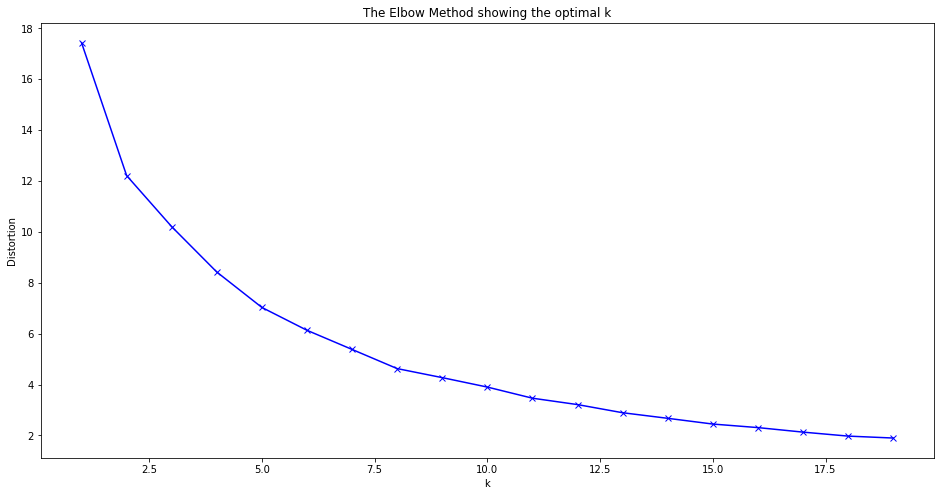

In [36]:

clustering_df= df.drop(columns=['Suburb','TotalEstablishments'])
clustering_df.head()
K= range(1,20)
distortions=[]
for k in K:
    Kmeans_model=KMeans(n_clusters=k)
    Kmeans_model.fit(clustering_df)
    distortions.append(Kmeans_model.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### We can observe that we get a good value at k=6. So we train our model with this value

In [43]:
print("Optimal k at 6")
Kmeans_model=KMeans(n_clusters=6).fit(clustering_df)
print(Kmeans_model.labels_[0:10])

Optimal k at 6
[4 4 4 4 4 4 4 4 4 4]


### And we add the labels to our dataframe

In [44]:
df['Cluster Label']=Kmeans_model.labels_
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Suburb,Latitude,Longitude,TotalBakeries,TotalCafeterias,TotalCreperies,TotalDonutshops,TotalEstablishments,Cluster Label
0,SAN NICOLAS TETELCO (PBLO),19.217583,-98.975739,0.0,0.0,0.0,0.0,0.0,4
1,"AYOCATITLA, ASUNCIN",19.184543,-99.147997,0.0,0.0,0.0,0.0,0.0,4
2,XAXALCO,19.192328,-99.141508,0.0,0.0,0.0,0.0,0.0,4
3,TEMPILULI,19.278847,-99.028314,0.0,0.0,0.0,0.0,0.0,4
4,SAN MIGUEL (AMPL),19.293127,-98.974118,0.0,0.0,0.0,0.0,0.0,4


### Let's get the main information of each cluster

## Cluster 1

In [45]:
cluster_1= df[df['Cluster Label']==1]
cluster1_bakeries= cluster_1['TotalBakeries'].mean()
cluster1_cafeterias=cluster_1['TotalCafeterias'].mean()
cluster1_creperies= cluster_1['TotalCreperies'].mean()
cluster1_donutshops=cluster_1['TotalDonutshops'].mean()
print("Cluster 1 Mean Bakeries : " +  str(cluster1_bakeries))
print("Cluster 1 Mean Cafeterias : " +  str(cluster1_cafeterias))
print("Cluster 1 Mean Creperies : " +  str(cluster1_creperies))
print("Cluster 1 Mean Donutshops : " +  str(cluster1_donutshops))


Cluster 1 Mean Bakeries : 0.78125
Cluster 1 Mean Cafeterias : 0.5002500000000001
Cluster 1 Mean Creperies : 0.5415
Cluster 1 Mean Donutshops : 0.5


## Cluster 2

In [46]:
cluster_2= df[df['Cluster Label']==2]
cluster2_bakeries= cluster_2['TotalBakeries'].mean()
cluster2_cafeterias=cluster_2['TotalCafeterias'].mean()
cluster2_creperies= cluster_2['TotalCreperies'].mean()
cluster2_donutshops=cluster_2['TotalDonutshops'].mean()
print("Cluster 2 Mean Bakeries : " +  str(cluster2_bakeries))
print("Cluster 2 Mean Cafeterias : " +  str(cluster2_cafeterias))
print("Cluster 2 Mean Creperies : " +  str(cluster2_creperies))
print("Cluster 2 Mean Donutshops : " +  str(cluster2_donutshops))

Cluster 2 Mean Bakeries : 0.46869230769230763
Cluster 2 Mean Cafeterias : 0.11123076923076924
Cluster 2 Mean Creperies : 0.14746153846153848
Cluster 2 Mean Donutshops : 0.0


## Cluster 3

In [47]:
cluster_3= df[df['Cluster Label']==3]
cluster3_bakeries= cluster_3['TotalBakeries'].mean()
cluster3_cafeterias=cluster_3['TotalCafeterias'].mean()
cluster3_creperies= cluster_3['TotalCreperies'].mean()
cluster3_donutshops=cluster_3['TotalDonutshops'].mean()
print("Cluster 3 Mean Bakeries : " +  str(cluster3_bakeries))
print("Cluster 3 Mean Cafeterias : " +  str(cluster3_cafeterias))
print("Cluster 3 Mean Creperies : " +  str(cluster3_creperies))
print("Cluster 3 Mean Donutshops : " +  str(cluster3_donutshops))

Cluster 3 Mean Bakeries : 0.4582222222222223
Cluster 3 Mean Cafeterias : 0.09888888888888889
Cluster 3 Mean Creperies : 0.6852222222222222
Cluster 3 Mean Donutshops : 0.037000000000000005


## Cluster 4

In [48]:
cluster_4= df[df['Cluster Label']==4]
cluster4_bakeries= cluster_4['TotalBakeries'].mean()
cluster4_cafeterias=cluster_4['TotalCafeterias'].mean()
cluster4_creperies= cluster_4['TotalCreperies'].mean()
cluster4_donutshops=cluster_4['TotalDonutshops'].mean()
print("Cluster 4 Mean Bakeries : " +  str(cluster4_bakeries))
print("Cluster 4 Mean Cafeterias : " +  str(cluster4_cafeterias))
print("Cluster 4 Mean Creperies : " +  str(cluster4_creperies))
print("Cluster 4 Mean Donutshops : " +  str(cluster4_donutshops))

Cluster 4 Mean Bakeries : 0.10737499999999998
Cluster 4 Mean Cafeterias : 0.019125
Cluster 4 Mean Creperies : 0.0
Cluster 4 Mean Donutshops : 0.0


## Cluster 5

In [49]:
cluster_5= df[df['Cluster Label']==5]
cluster5_bakeries= cluster_5['TotalBakeries'].mean()
cluster5_cafeterias=cluster_5['TotalCafeterias'].mean()
cluster5_creperies= cluster_5['TotalCreperies'].mean()
cluster5_donutshops=cluster_5['TotalDonutshops'].mean()
print("Cluster 5 Mean Bakeries : " +  str(cluster5_bakeries))
print("Cluster 5 Mean Cafeterias : " +  str(cluster5_cafeterias))
print("Cluster 5 Mean Creperies : " +  str(cluster5_creperies))
print("Cluster 5 Mean Donutshops : " +  str(cluster5_donutshops))

Cluster 5 Mean Bakeries : 0.28650000000000003
Cluster 5 Mean Cafeterias : 0.10658333333333335
Cluster 5 Mean Creperies : 0.13891666666666666
Cluster 5 Mean Donutshops : 0.4443333333333334


## Cluster 0

In [50]:
cluster_0= df[df['Cluster Label']==0]
cluster0_bakeries= cluster_0['TotalBakeries'].mean()
cluster0_cafeterias=cluster_0['TotalCafeterias'].mean()
cluster0_creperies= cluster_0['TotalCreperies'].mean()
cluster0_donutshops=cluster_0['TotalDonutshops'].mean()
print("Cluster 0 Mean Bakeries : " +  str(cluster4_bakeries))
print("Cluster 0 Mean Cafeterias : " +  str(cluster4_cafeterias))
print("Cluster 0 Mean Creperies : " +  str(cluster4_creperies))
print("Cluster 0 Mean Donutshops : " +  str(cluster4_donutshops))

Cluster 0 Mean Bakeries : 0.10737499999999998
Cluster 0 Mean Cafeterias : 0.019125
Cluster 0 Mean Creperies : 0.0
Cluster 0 Mean Donutshops : 0.0


### For a better visualization we put it in a dataframe

In [52]:
clusters_dict= {'Clusters':[1,2,3,4,5,0], 'Mean Bakeries':[cluster1_bakeries, cluster2_bakeries,cluster3_bakeries, cluster4_bakeries,cluster5_bakeries, cluster0_bakeries],
               'Mean Cafeterias':[cluster1_cafeterias,cluster2_cafeterias,cluster3_cafeterias,cluster4_cafeterias,cluster5_cafeterias,cluster0_cafeterias],
               'Mean Creperies':[cluster1_creperies,cluster2_creperies,cluster3_creperies,cluster4_creperies,cluster5_creperies, cluster0_creperies],
               'Mean Donutshops':[cluster1_donutshops, cluster2_donutshops, cluster3_donutshops, cluster4_donutshops, cluster5_donutshops, cluster0_donutshops]}
cluster_df= pd.DataFrame(clusters_dict)
cluster_df

,Clusters,Mean Bakeries,Mean Cafeterias,Mean Creperies,Mean Donutshops
0,1,0.781250,0.500250,0.541500,0.500000
1,2,0.468692,0.111231,0.147462,0.000000
2,3,0.458222,0.098889,0.685222,0.037000
3,4,0.107375,0.019125,0.000000,0.000000
4,5,0.286500,0.106583,0.138917,0.444333
5,0,0.187529,0.052294,0.294059,0.000000


### Now let's just put them in a map

In [53]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, 11))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Suburb'], df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and discussion

#### Our analysis shows that there are some suburb centers in Mexico City that do not count with direct competitors (considering a 1km radius area). These are the areas that are consider to be the best to place our franchise. If, for some reason, there is the need to consider other areas, the general recommendation is to use the TotalEstablishments variable to refer other areas, the lower value, the better recommendation.

#### As the analysis was done, we notice that in the near future, we will notice that among these direct competitors, there would be some that represent a stronger competition than others, so as a base for future analysis, we created clusters based on the density per kind of competitors around the area in order to consider other suburbs for future franchises. In this part of the analysis we notice that the best k for clustering is 6, and it represents the number of characteristics used for training the model, one per direct cometitor. Through the visualization of the clusters' density of main competitors we can take future decisions on where to place other franchises.

## Conclusion

#### The purpose of this project was to identify the best suburbs in Mexico City to place a bakery, this objective was partially limited because the Foursquare API's free suscription didn't allow more requests. Nevertheless, the code supports the iteration of the complete dataset in case of having a Premium suscription.

#### Apart from this, the project allows us to take the decission on where we can place a franchise based on the density of local competitors around the area. 